# Light-Field Microscopy forward projector 
### This script's intension is to provide an easy Light-Field microscopy forward projection.
## Usage:
* Create a .lfc calibration file containing the LF PSFs with napari-LF
    * Open napari-LF and select an empty project directory or the provided directory.
    * Set the calibration parameters and hit calibrate, this will create a metadata.txt file, which you need to modify.
    * In metadata.txt: set "synthetic_lf": true, "skip_alignment": true, "skip_subpixel_alignment": true
    * And specify:  "num_slices": 3, "um_per_slice": 1.0, "supersample": 33, along all the parameters of your microscope.
    * Then click calibrate, which will generate your PSF inide a .lfc file

In [2]:
## library imports and helper functions
import numpy as np
import os
import subprocess
import time
import tempfile
import argparse
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
# lflib imports
import lflib
from lflib.imageio import load_image, save_image
from lflib.lightfield import LightField
from lflib.calibration import LightFieldCalibration
from lflib.util import ensure_path
from lflib.volume import LightFieldProjection
from lflib.linear_operators import LightFieldOperator
import lfdeconvolve

def interpolate(img, new_shape):
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
    try:
        img = F.interpolate(img.float(), new_shape, mode='trilinear')
    except:
        img = F.interpolate(img.float(), new_shape)
    return img[0,0,...].numpy()

def MIP(vol, scaling_factors=[1,1,1]):
    vol_size = list(vol.shape)
    vol_size = [int(vol.shape[i] * scaling_factors[i]) for i in range(len(scaling_factors))]
    print(vol_size)
    x_projection = np.amax(vol, 1)
    y_projection = np.amax(vol, 0)
    z_projection = np.amax(vol, 2)

    out_img = z_projection.min() * np.ones(
        (vol_size[0]+vol_size[2], vol_size[1]+vol_size[2])
    )
    out_img[:vol_size[0], : vol_size[1]] = interpolate(z_projection, vol_size[0:2])
    proj = interpolate(x_projection, [vol_size[1],vol_size[2]])
    out_img[:vol_size[0], vol_size[1]:] = proj
    print(f'xproj {proj.shape}')
    proj = interpolate(y_projection, [vol_size[0],vol_size[2]])
    print(f'yproj {proj.shape}')
    out_img[vol_size[0]:, :vol_size[1]] = proj.transpose(1,0)

    line_color = out_img.max()
    # Draw white lines
    out_img[:, vol_size[1]] = line_color
    out_img[vol_size[0],:] = line_color
    return out_img


/space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fcba47e6d30>()] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/ioloop.py:687] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/gen.py:874> took 1.134 seconds


### Define project path and load .lfc file containing PSF's computed in Napari-LF

In [3]:
# Inputs #########################################################################################
# Simulated GUV
project_path = 'C:/Users/OldenbourgLab2/Code/napari-LF-develop/docs/GUV_Rudolfs_settings/'
calibration_path = f'{project_path}/Calibration-SS4.lfc'

#########################################################################################
# Load the calibration data
lfcal = LightFieldCalibration.load(calibration_path)

if lfcal.psf_db is not None:
    print('\t    Using wave optic psf db.')
    db = lfcal.psf_db
else:
    print('\t    Using rayspread db.')
    db = lfcal.rayspread_db

# Create a LFprojection object
lfproj = LightFieldProjection(lfcal.rayspread_db, lfcal.psf_db,
                                disable_gpu = False, gpu_id = 0, platform_id = 0, use_sing_prec=True)
# Gather some dimensional information stored in the calibration file
nrays = db.ns*db.nu*db.nt*db.nv
nvoxels = db.nx*db.ny*db.nz
# Create LF linear operator, which allows for forward/backward projection
A_lfop = LightFieldOperator(lfproj, db, True)
A_operator = A_lfop.as_linear_operator(nrays, nvoxels)

	    Using wave optic psf db.
platform id:  0  | platform:  <pyopencl.Platform 'NVIDIA CUDA' at 0x55a602ae4060>
device:  <pyopencl.Device 'NVIDIA GeForce RTX 2080 Ti' on 'NVIDIA CUDA' at 0x55a604e637a0>
device:  <pyopencl.Device 'NVIDIA GeForce RTX 2080 Ti' on 'NVIDIA CUDA' at 0x55a604cc1fe0>
Using single precision option (--use-single-precision)


Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fcbac1e90d0>()] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/ioloop.py:687] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/gen.py:874> took 2.718 seconds


### Extract PSFs

100%|██████████| 104/104 [09:39<00:00,  5.57s/it]


[416, 416, 104]
xproj (416, 104)
yproj (416, 104)


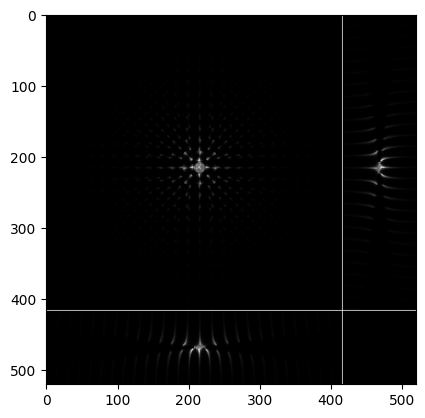

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fca50407ca0>()] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/ioloop.py:687] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/gen.py:874> took 579.992 seconds


In [5]:
# Extract psf of coords relative to the center of the image
coord_x,coord_y = 1,1
# all the depths?
depths_to_extract = list(range(db.nz))
# or just some of them?
# depths_to_extract = [db.nz//2]


from tqdm import tqdm
volume = np.zeros((db.ny, db.nx, db.nz))
mid_volume = [db.ny//2,db.nx//2]
# Define output volume
psf_out = np.zeros((db.nu*db.ns,db.nv*db.nt,db.nz))
for nz in tqdm(depths_to_extract):
    volume *= 0
    volume[mid_volume[0]+coord_y, mid_volume[1]+coord_x, nz] = 1
    image_vec = A_operator.matvec(volume.reshape(db.nvoxels))
    # Reshape result
    image_views_2D = np.reshape(image_vec, (db.nu*db.ns, db.nv*db.nt))
    lf = LightField(image_views_2D, db.nu, db.nv, db.ns, db.nt,
                            representation = LightField.TILED_SUBAPERTURE)
    # Generate LF image
    psf = lf.asimage(representation = LightField.TILED_LENSLET)
    psf_out[:,:,nz] = psf

plt.imshow(MIP(psf_out),cmap='gray')
save_image(f'{project_path}/psf_stack.tif', psf_out, dtype=np.float32)


	expected volume dimensions: (104,104,104)   current volume dimensions: (104, 104, 104)
	LF shape (16,16) (26,26)
Forward projecting volume
[104, 104, 104]
xproj (104, 104)
yproj (104, 104)


<Figure size 640x480 with 0 Axes>

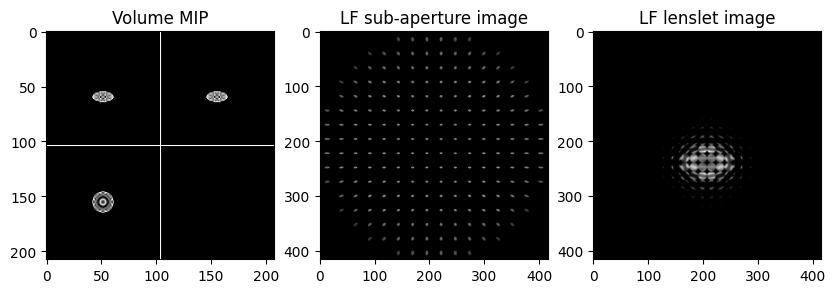

Projetcion saved to: 
/u/home/vizcainj/code/napari-LF/docs/GUVSimul1//Simulated_WaveOptics_LF.tif


Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fca5035be20>()] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/ioloop.py:687] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/gen.py:874> took 5.864 seconds


In [7]:
# Create a volume
volume = np.zeros((db.ny, db.nx, db.nz))
# Or load a volume
volume = load_image(f'{project_path}/GUVSimul1_VolumeGroundTruth.tif')
# Volume transformations [y,x,z]
translation = [8,0,0]
volume_new_size = [10,20,20]



##################################
# Rescaling 
volume = interpolate(volume,volume_new_size)
# Correct volume size by padding zeros
extra_offset = 0
volume = np.pad(volume, (((db.ny-volume.shape[0])//2+extra_offset,(db.ny-volume.shape[0])//2),
                            ((db.nx-volume.shape[1])//2+extra_offset,(db.nx-volume.shape[1])//2),
                            ((db.nz-volume.shape[2])//2,(db.nz-volume.shape[2])//2)))
# Translation 
for ix,t in enumerate(translation):
    volume = np.roll(volume, t, ix)
print(f'\texpected volume dimensions: ({db.ny},{db.nx},{db.nz})   current volume dimensions: {volume.shape}')
print(f'\tLF shape ({db.nu},{db.nv}) ({db.ns},{db.nt})')
print('Forward projecting volume')
# And forward project
volume_vec = volume.reshape(db.nvoxels)
image_vec = A_operator.matvec(volume_vec)

# Reshape result
image_views_2D = np.reshape(image_vec, (db.nu*db.ns, db.nv*db.nt))
lf = LightField(image_views_2D, db.nu, db.nv, db.ns, db.nt,
                          representation = LightField.TILED_SUBAPERTURE)
# Generate LF image
image_lenslets_2D = lf.asimage(representation = LightField.TILED_LENSLET)

# Show image
plt.clf()
plt.figure(figsize=(10,30))
plt.subplot(1,3,1)
plt.imshow(MIP(volume), cmap='gray')
plt.title('Volume MIP')
plt.subplot(1,3,2)
plt.imshow(image_views_2D, cmap='gray')
plt.title('LF sub-aperture image')
plt.subplot(1,3,3)
plt.imshow(image_lenslets_2D, cmap='gray')
plt.title('LF lenslet image')
plt.show()

print(f'Projetcion saved to: \n{project_path}/Simulated_WaveOptics_LF.tif')
save_image(f'{project_path}/Simulated_WaveOptics_LF.tif', image_lenslets_2D, dtype=np.float32)
# save_image(f'{project_path}/Radiometry_WaveOptics.tif', image_lenslets_2D, dtype=np.float32)
# save_image(f'{project_path}/Dark_Frame_WaveOptics.tif', image_lenslets_2D, dtype=np.float32)

581.87616 2364.4585


/mnt/cephstorage/users-ssd/vizcainj/code/napari-LF/src/napari_lf/lfa/lflib/solvers/richardson_lucy.py:93: RuntimeWarning: invalid value encountered in divide
  v = A.rmatvec(b / c)


	--> [ RL Iteration 0   (10.43 seconds) ] 
	      Residual Norm: 0.4476               (tol = 1.00e-06)  
	        Update Norm: 5697                              
	--> [ RL Iteration 1   (10.32 seconds) ] 
	      Residual Norm: 0.2785               (tol = 1.00e-06)  
	        Update Norm: 0.0002765                              
	--> [ RL Iteration 2   (10.22 seconds) ] 
	      Residual Norm: 0.224               (tol = 1.00e-06)  
	        Update Norm: 0.0001423                              
	--> [ RL Iteration 3   (10.07 seconds) ] 
	      Residual Norm: 0.1983               (tol = 1.00e-06)  
	        Update Norm: 9.096e-05                              
	--> [ RL Iteration 4   (10.06 seconds) ] 
	      Residual Norm: 0.1823               (tol = 1.00e-06)  
	        Update Norm: 6.771e-05                              
	--> [ RL Iteration 5   (10.13 seconds) ] 
	      Residual Norm: 0.1708               (tol = 1.00e-06)  
	        Update Norm: 5.526e-05                              
	-->

<Figure size 640x480 with 0 Axes>

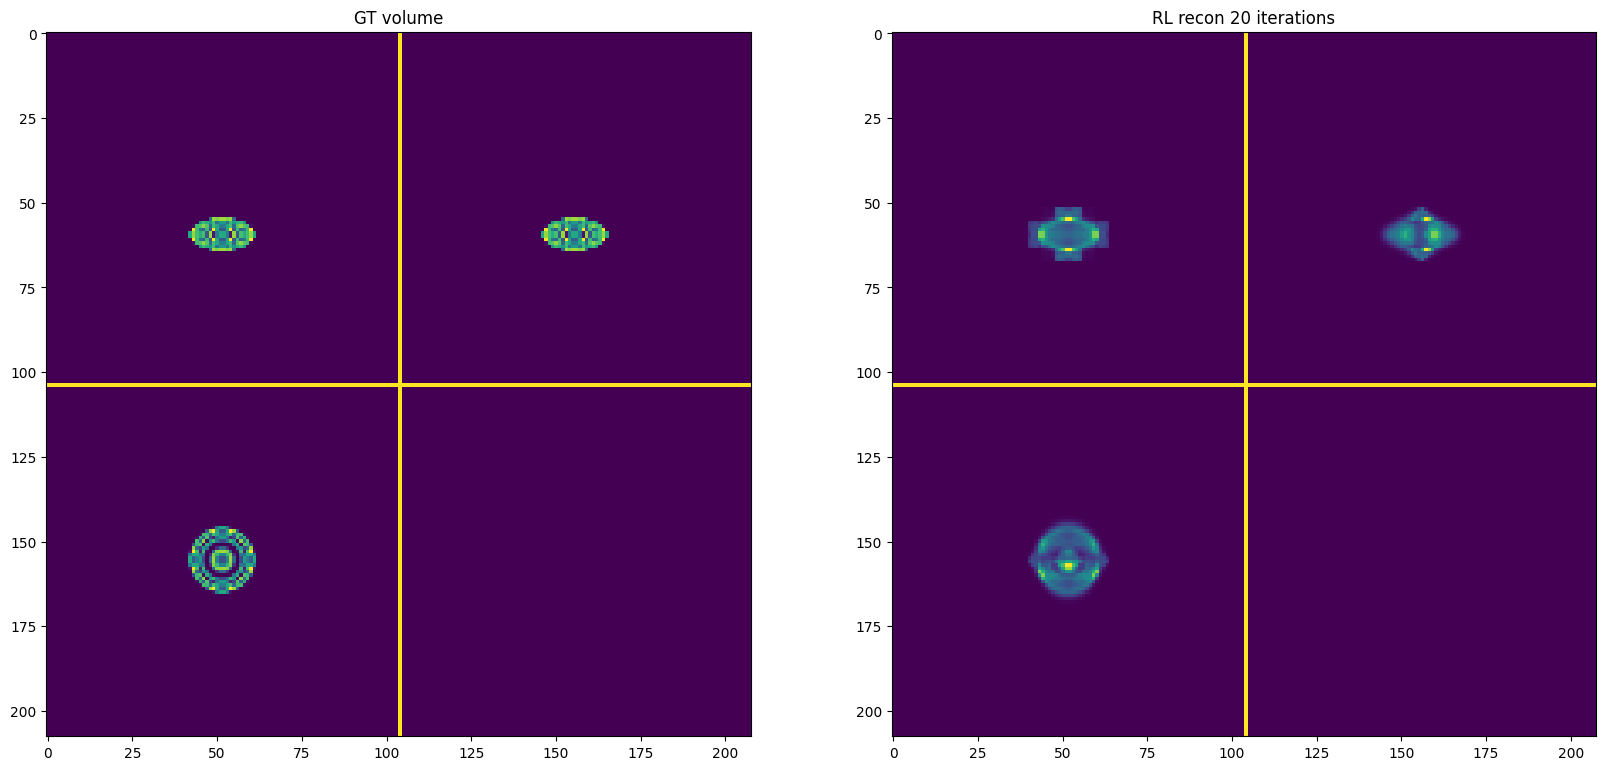

GT and recon saved to: /u/home/vizcainj/code/napari-LF/docs/GUVSimul1/ as vol_gt.tif and vol_recon.tiv


Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/ipykernel/kernelbase.py:512> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fca50204100>()] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/ioloop.py:687] created at /space/vizcainj/virtualenvs/napari-LF/lib/python3.9/site-packages/tornado/gen.py:874> took 218.794 seconds


In [9]:
## Deconvolve volume
max_iter = 20
conv_thresh = 1e-6

# Both ray and wave optics
reconstructions = []
images_to_process = [image_views_2D]
b_vec = np.reshape(image_views_2D, np.prod(image_views_2D.shape))

# Deconvolution
from lflib.solvers.richardson_lucy import richardson_lucy_reconstruction
x_vec = richardson_lucy_reconstruction(A_operator, b_vec,
                                        Rtol = conv_thresh,
                                        max_iter = max_iter,
                                        beta = 0.0,
                                        sigmaSq = 0.0)

# Turn back to volume shape
vol_recon = np.reshape(x_vec, (db.ny, db.nx, db.nz))
    
# And show results
mip_gt = MIP(volume,[1,1,1])
plt.clf()
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(mip_gt)
plt.title('GT volume')
mip_pred = MIP(vol_recon, [1,1,1])
plt.subplot(1,2,2)
plt.imshow(mip_pred)
plt.title(f'RL recon {max_iter} iterations')
plt.show()

print(f'GT and recon saved to: {project_path} as vol_gt.tif and vol_recon.tiv')
save_image(f'{project_path}/vol_recon_{max_iter}iter.tif', vol_recon, dtype=np.float32)
save_image(f'{project_path}/vol_gt.tif', volume, dtype=np.float32)